# Exploratory Data Analysis and Data Cleansing of DIamonds Dataset

This notebook provides an initial insight into the data in the diamonds dataset. This is done using data visualisation techniques and is a useful tool for assessing what modelling technqiues might be appropriate and provides some direction for the project. 

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import seaborn as sns

In [2]:
#Read the csv file in using pandas - a data parsing tool
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
# This step provides an initial view of the data - much easier to gain insight than printing the dataframe
diamonds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Index      53940 non-null int64
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


**There is non-numerical data which will require changing into numerical data before inputting into models.**

In [4]:
#This step provides a description of the numerical data.
diamonds_df.describe()

,Index,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


**The data is in a non-standard form, this is potentialiy problematic since machine learning algorithms tend to work best on standardised data - a pre-processing step of standardisation (mean subtraction and division by the standard deviation) will be required before inputting the data into any model.**

In [73]:
diamonds_df.isnull().sum()

Index      0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

**There are no missing values, so no data cleansing steps are required such as replacing missing values with median values or removing incomplete rows.** 

In [74]:
diamonds_df['clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [75]:
diamonds_df['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [76]:
diamonds_df['color'].value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [77]:
diamonds_df['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [78]:
#Replacing categorial values with numerical values 
#sklearn has an existing library for this however it is unlikely to be able to recognise how the input values are arranged
clarity_dict={'FL':1, 'IF':2, 'VVS1':3, 'VVS2':4, 'VS1':5, 'VS2':6,'SI1':7, 'SI2':8,'I1':9,'I2':10,'I3':11}
cut_dict = {'Ideal':1, 'Premium':2, 'Very Good':3, 'Good':4, 'Fair':5}

In [5]:
#Cut has an obvious ordinality so the ordinal encoder should be able to encode the data properly
diamonds2 = diamonds_df.copy()
oe = OrdinalEncoder()
color_array = np.array(diamonds2['color']).reshape(-1,1)
diamonds2['color'] = oe.fit_transform(color_array)

In [80]:
diamonds2['color'].value_counts()
#compared with original, the encoder has worked as intended

3.0    11292
1.0     9797
2.0     9542
4.0     8304
0.0     6775
5.0     5422
6.0     2808
Name: color, dtype: int64

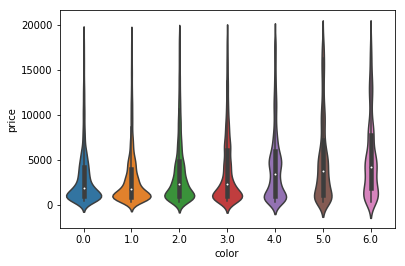

In [105]:
sns.violinplot(x='color',y='price',data=diamonds2)

**The violin plot shows a slight change in distribution of prices for each colour, however the progression and change of distribution isn't sufficiently large for a simple heuristic linking price to colour to work effectively**

In [82]:
correlation_df = diamonds_df[['price', 'x','y','z','depth','table']]
corr_matrix = correlation_df.corr()

In [83]:
corr_matrix['price'].sort_values(ascending=False)

price    1.000000
x        0.884435
y        0.865421
z        0.861249
table    0.127134
depth   -0.010647
Name: price, dtype: float64

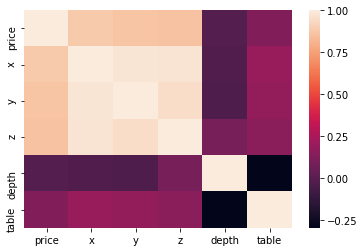

In [84]:
#Plot the correlations between the dimension values of the diamonds
sns.heatmap(corr_matrix)

**This heatmap shows there is a high correlation between x,y,z dimensions: useful for dimensionality reduction.. (see principal component analysis notebook)**

In [85]:
#Saving mean and std values of conntinuous data that is standardised for future reference
standardise_info = pd.DataFrame()
standardised_elements = ['price','x','y','z','depth','table']
for i in range(len(standardised_elements)):
    index = standardised_elements[i]
    mean = diamonds_df[index].mean()
    std = diamonds_df[index].std()
    standardise_info[index] = [{'mean':mean,'std':std}]

cwd = os.getcwd()
file_name = 'standardise_vals.csv'
standardise_info.to_csv(os.path.join(cwd,file_name))

In [86]:
#SKlearns StandardScaler normalises data by subtracting the mean and dividing by the standard deviation
ss = StandardScaler()
input_df = pd.DataFrame()

In [87]:
price_rescale = ss.fit_transform(np.array(correlation_df['price']).reshape(-1,1))
depth_rescale = ss.fit_transform(np.array(correlation_df['depth']).reshape(-1,1))
table_rescale = ss.fit_transform(np.array(correlation_df['table']).reshape(-1,1))
x_rescale = ss.fit_transform(np.array(correlation_df['x']).reshape(-1,1))
y_rescale = ss.fit_transform(np.array(correlation_df['y']).reshape(-1,1))
z_rescale= ss.fit_transform(np.array(correlation_df['z']).reshape(-1,1))

C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [88]:
input_df['price'] = price_rescale.flatten()
input_df['depth'] = depth_rescale.flatten()
input_df['table'] = table_rescale.flatten()
input_df['x'] = x_rescale.flatten()
input_df['y'] = y_rescale.flatten()
input_df['z'] = z_rescale.flatten()
input_df['color'] = diamonds2['color']

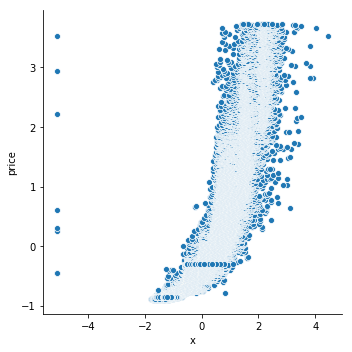

In [89]:
sns.relplot('x','price',data=input_df)

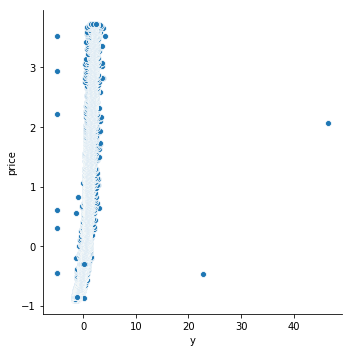

In [90]:
sns.relplot('y','price',data=input_df)

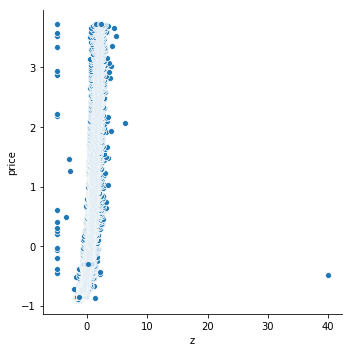

In [91]:
sns.relplot('z','price',data=input_df)

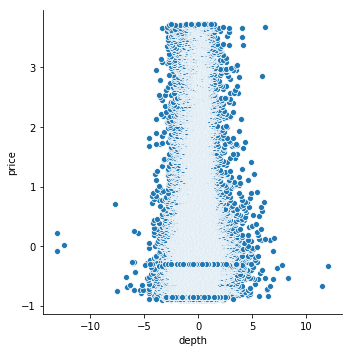

In [92]:
sns.relplot('depth','price',data=input_df)

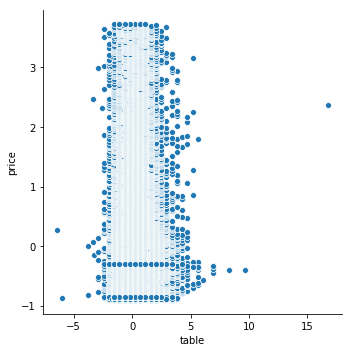

In [93]:
sns.relplot('table','price',data=input_df)

In [94]:
clarity_list = []
cut_list = []
for i in range(len(diamonds_df)):
    clarity = diamonds_df['clarity'].loc[i]
    cut = diamonds_df['cut'].loc[i]
    clarity_list.append(clarity_dict[clarity])
    cut_list.append(cut_dict[cut])

In [95]:
input_df['clarity'] = np.array(clarity_list)
input_df['cut'] = np.array(cut_list)

C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


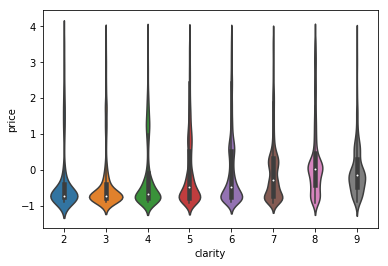

In [103]:
sns.violinplot('clarity','price',data=input_df)

**The violin plot shows a slight change in distribution of prices for each clarity, however the progression and change of distribution isn't sufficiently large for a simple heuristic linking price to clarity to work effectively**

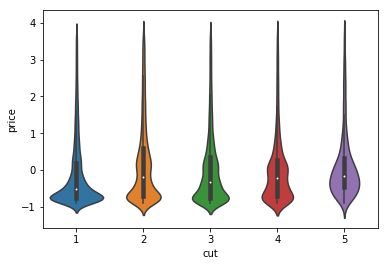

In [104]:
sns.violinplot('cut','price',data=input_df)

**The violin plot shows a slight change in distribution of prices for each cut, however the progression and change of distribution isn't sufficiently large for a simple heuristic linking price to cut to work effectively**

In [98]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
price      53940 non-null float64
depth      53940 non-null float64
table      53940 non-null float64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
color      53940 non-null float64
clarity    53940 non-null int32
cut        53940 non-null int32
dtypes: float64(7), int32(2)
memory usage: 3.3 MB


In [99]:
#Splitting the data up into train, validation and test sets
#The ratio of train:val:test is 3:1:1
train_val, test = train_test_split(input_df, train_size=0.8, random_state=43)
train,val = train_test_split(train_val, train_size = 0.75, random_state=43)

C:\Users\Rajeev\Anaconda3\envs\development\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [100]:
#Data cleansing step - the train_test_split jumbles the indexes of the dataframes and so each data frame requires a dataframe reset
train = train.reset_index()
val = val.reset_index()
test = test.reset_index()

In [102]:
#Saving the dataframes
cwd = os.getcwd()
train_name = 'train.csv'
val_name = 'val.csv'
test_name = 'test.csv'
train.to_csv(os.path.join(cwd,train_name))
val.to_csv(os.path.join(cwd,val_name))
test.to_csv(os.path.join(cwd,test_name))